# Ideal Diode Example

The simplest way to model a solar cell is as an **ideal diode**, described by the following equation:
$$J(V,T) = J_L+J_0(\exp{\frac{qV}{nkT}}-1)$$
where $k=8.61733\times 10^{-5}$ eV/K is Boltzmann's constant, by convention $J_L$ (the light current) is negative and $J_0$ (the saturation current) is positive but strongly dependent on temperature, a dependence we can approximate as:
$$J_0 \approx B'T^{3/n}\exp{\frac{-E_{g0}}{nkT}}$$
We'll use the silicon zero-temperature bandgap, $E_{g0}=1.2$ eV, meaning we just need to fit for $B'$ in this equation.
$J_L$ is typically directly proportional to light intensity, which we will treat as fixed for this example, leaving us with two parameters to fit for: $B'$ and the ideality factor $n$.

In [1]:
import numpy as np
import sys
import math
import pandas as pd
sys.path.append('../../')
import bayesim.model as bym
import bayesim.param_list as byp
import deepdish as dd
from jupyterthemes import jtplot
jtplot.style('default')

## List the parameters
First, we list our fitting parameters.

In [2]:
fp = byp.param_list()
fp.add_fit_param(name='Bp',val_range=[10,1000],spacing='log',length=15,units='arb.')
fp.add_fit_param(name='n',val_range=[1,2],length=15)

We can inspect the `param_list` object and see what kind of information is inside...

In [3]:
fp.fit_params

[{'edges': array([   10.        ,    13.59356391,    18.47849797,    25.11886432,
            34.14548874,    46.41588834,    63.09573445,    85.76958986,
           116.59144012,   158.48931925,   215.443469  ,   292.86445646,
           398.10717055,   541.16952655,   735.64225446,  1000.        ]),
  'length': 15,
  'min_width': 1.0311772745930552,
  'name': 'Bp',
  'spacing': 'log',
  'units': 'arb.',
  'val_range': [10, 1000],
  'vals': array([  11.65914401,   15.84893192,   21.5443469 ,   29.28644565,
           39.81071706,   54.11695265,   73.56422545,  100.        ,
          135.93563909,  184.78497974,  251.18864315,  341.45488738,
          464.15888336,  630.95734448,  857.69589859])},
 {'edges': array([ 1.        ,  1.06666667,  1.13333333,  1.2       ,  1.26666667,
          1.33333333,  1.4       ,  1.46666667,  1.53333333,  1.6       ,
          1.66666667,  1.73333333,  1.8       ,  1.86666667,  1.93333333,  2.        ]),
  'length': 15,
  'min_width': 0.0066666666666

Note that there are both `edges` and `vals` computed - the `vals` will be the values at which computations will be done, while `edges` will be the edges of the grid, used in subdivision steps later on.

Finally, we define the measurement conditions. We won't be varying light intensity here, so we only need voltage and temperature.

In [4]:
ec = ['V','T']

In [5]:
m = bym.model(params=fp,ec=ec,output_var='J')

In [6]:
m.probs.points.head(11)

,Bp,Bp_min,Bp_max,n,n_min,n_max,new,prob,num_sub
0,11.659144,10.0,13.593564,1.033333,1.000000,1.066667,1.0,0.004444,0
1,11.659144,10.0,13.593564,1.100000,1.066667,1.133333,1.0,0.004444,0
2,11.659144,10.0,13.593564,1.166667,1.133333,1.200000,1.0,0.004444,0
3,11.659144,10.0,13.593564,1.233333,1.200000,1.266667,1.0,0.004444,0
4,11.659144,10.0,13.593564,1.300000,1.266667,1.333333,1.0,0.004444,0
5,11.659144,10.0,13.593564,1.366667,1.333333,1.400000,1.0,0.004444,0
6,11.659144,10.0,13.593564,1.433333,1.400000,1.466667,1.0,0.004444,0
7,11.659144,10.0,13.593564,1.500000,1.466667,1.533333,1.0,0.004444,0
8,11.659144,10.0,13.593564,1.566667,1.533333,1.600000,1.0,0.004444,0
9,11.659144,10.0,13.593564,1.633333,1.600000,1.666667,1.0,0.004444,0


## Attach experimental data
This is the next step that needs to be done before adding the model as it will use the experimental conditions we enumerate here to compute simulated outputs. For our "experimental" data here, we'll actually just simulate some ideal diodes so that we can directly see how good the Bayesian approach is at recovering true underlying parameters.

We'll use $n=1.36$ and $B'=258$ as our "true" parameters. (I have no idea what "realistic" values for $B'$ would be...)

In [7]:
def compute_ID(ec,params):
    J_L = -0.03 # treat as fixed for now
    V = ec['V']
    T = ec['T']
    V_th = 8.61733e-5 * T # thermal voltage, kT/q
    n = params['n']
    Bp = params['Bp']
    J0 = Bp*T**(3/n)*math.exp(-1.2/V_th/n)
    return J_L + J0*(math.exp(V/V_th/n)-1)

V = np.arange(0,1.0,0.01)
#V = np.arange(0,1.0,0.01)
T = [float(t) for t in np.arange(150,301,50)]
params = {'n':1.36,'Bp':258}

data = []
for t in T:
    J0 = compute_ID({'V':V[0],'T':t},params)
    for v in V:
        J = compute_ID({'V':v,'T':t},params)
        if abs(J)>0.05:
            err = 0.05*abs(J)
        else:
            err = 0.005
        # check for "compliance"
        if not J > 1.0:
            data.append([v,t,J,err])
        
data = pd.DataFrame.from_records(data=data,columns=['V','T','J','error'])
dd.io.save('obs_data.h5',data)

In [8]:
m.attach_observations(fpath='obs_data.h5',ec_x_var='V',max_ec_x_step=0.2)
#m.attach_observations(fpath='obs_data.h5',fixed_error=0.01,ec_x_var='V',max_ec_x_step=0.075)
#m.attach_observations(fpath='obs_data.h5',fixed_error=0.01,ec_x_var='V',keep_all=True)

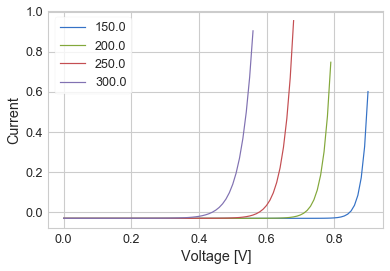

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
leg = []
for i in range(len(T)):
    curve = data[data['T']==T[i]]
    plt.plot(curve['V'],curve['J'])
    leg.append(curve['T'].iloc[0])
#plt.ylim([-0.05,0.1])
plt.legend([str(t) for t in leg])
plt.xlabel('Voltage [V]')
plt.ylabel('Current')
plt.show()

## Attach model
Now we add the function that gives the modeled data - in this case, the `compute_ID` function we just defined above.

In [10]:
m.attach_model(mode='function',func_name=compute_ID)
#m.attach_model(mode='file',fpath='model_data.h5')

That's it! When that function is called, `bayesim` also generates the full table of modeled data at all experimental conditions in the observed data we attached before. Check it out:

In [11]:
m.calc_model_gradients()

## Drop that Bayes!
### First Bayes
Let's run the first round. We'll use the default parameters which means it will run three times using randomly chosen observations (without replacement) until 80% of the probability is in 5% of the boxes. Then it will average the PMF's from those three runs to create the result.

In [12]:
m.run()

Did a total of 6 runs to use a total of 52 observations.


We can visualize the distribution and add markers for the real values to compare...

setup finished in 0.36 seconds
project_1D took 0.11 seconds
diagonal plot finished in 0.13 seconds
project_2D took 0.05 seconds
off-diagonal plot finished in 0.1 seconds
project_1D took 0.09 seconds
diagonal plot finished in 0.11 seconds


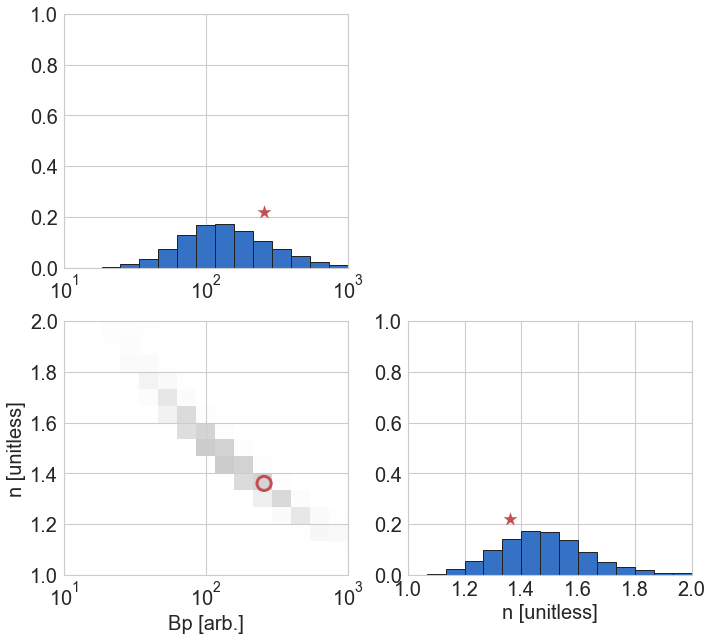

In [13]:
m.visualize_probs(true_vals=params)

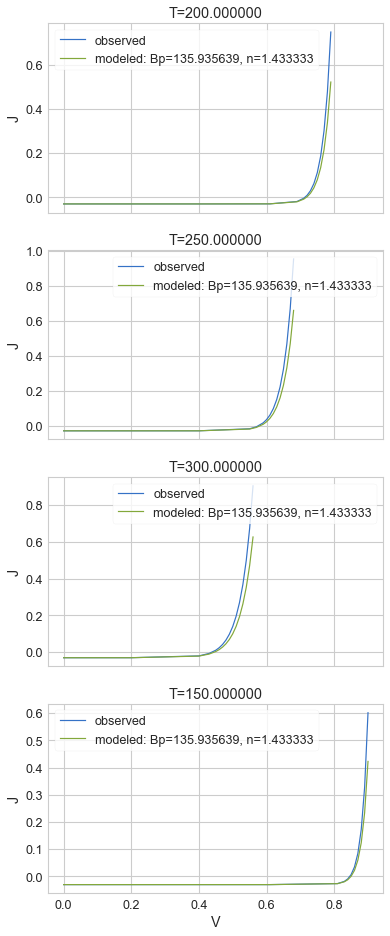

In [14]:
m.comparison_plot(ecs=[{'T':t} for t in list(set(list(m.ec_pts['T'])))])

Not too bad. We can also look at the probabilities directly.

In [15]:
m.probs.most_probable(10)

,Bp,Bp_min,Bp_max,n,n_min,n_max,new,prob,num_sub,start_ind,end_ind
126,135.935639,116.591440,158.489319,1.433333,1.400000,1.466667,1.0,0.089739,0,7308,7365
112,100.000000,85.769590,116.591440,1.500000,1.466667,1.533333,1.0,0.088561,0,6496,6553
127,135.935639,116.591440,158.489319,1.500000,1.466667,1.533333,1.0,0.078909,0,7366,7423
141,184.784980,158.489319,215.443469,1.433333,1.400000,1.466667,1.0,0.078327,0,8178,8235
155,251.188643,215.443469,292.864456,1.366667,1.333333,1.400000,1.0,0.076278,0,8990,9047
113,100.000000,85.769590,116.591440,1.566667,1.533333,1.600000,1.0,0.075741,0,6554,6611
169,341.454887,292.864456,398.107171,1.300000,1.266667,1.333333,1.0,0.065839,0,9802,9859
99,73.564225,63.095734,85.769590,1.633333,1.600000,1.666667,1.0,0.063242,0,5742,5799
140,184.784980,158.489319,215.443469,1.366667,1.333333,1.400000,1.0,0.062384,0,8120,8177
98,73.564225,63.095734,85.769590,1.566667,1.533333,1.600000,1.0,0.057421,0,5684,5741


### Let's subdivide!
Again we'll use the default options, which will subdivide all grid boxes with probability > 0.001 as well as any immediately adjacent boxes.

In [16]:
m.subdivide()

36 box(es) with probability > 0.001 and 28 neighboring boxes subdivided!
New model points to simulate are saved in the file new_sim_points_1.h5.


Let's take a look at the grid.

setup finished in 0.43 seconds
project_2D took 0.38 seconds
off-diagonal plot finished in 0.92 seconds


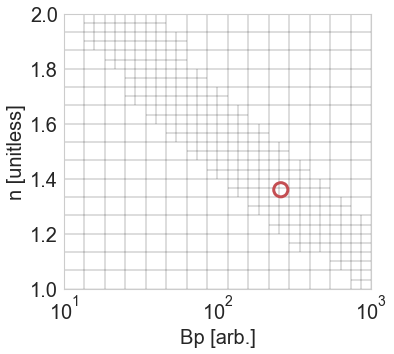

In [17]:
m.visualize_grid(true_vals=params)

### Compute and attach new model data
We've added new model points to the grid so we have to compute the modeled values and attach that data.

In [18]:
new_sims = dd.io.load('new_sim_points_1.h5')

In [19]:
data = []
for sim in new_sims.iterrows():
    v = sim[1]['V']
    t = sim[1]['T']
    this_pt = [v,t,compute_ID({'V':v,'T':t},sim[1])]
    this_pt.extend([sim[1][n] for n in m.param_names])
    data.append(this_pt)
columns = ['V','T','J']
columns.extend(m.param_names)
new_sim_data = pd.DataFrame.from_records(data=data,columns=columns)
dd.io.save('new_sim_data_1.h5',new_sim_data)

In [20]:
m.attach_model(mode='add',fpath='new_sim_data_1.h5')

In [21]:
m.calc_model_gradients()

In [ ]:
m.model_data.head()

,Bp,J,T,V,deltas,error,n
0,11.659144,-0.030000,150.0,0.00,0.000000e+00,0.000000e+00,1.033333
1,11.659144,-0.030000,150.0,0.20,0.000000e+00,0.000000e+00,1.033333
2,11.659144,-0.030000,150.0,0.40,3.469447e-18,3.469447e-18,1.033333
3,11.659144,-0.030000,150.0,0.61,7.972019e-12,7.972019e-12,1.033333
4,11.659144,-0.029995,150.0,0.81,7.227807e-06,7.227807e-06,1.033333


### Second Bayes!
Let's do it again!

In [ ]:
m.run()

In [ ]:
m.visualize_probs(true_vals=params)

In [ ]:
m.probs.most_probable(10)

In [ ]:
m.comparison_plot(num_param_pts=3)

In [ ]:
m.subdivide()

In [ ]:
m.visualize_grid(true_vals=params)

In [ ]:
new_sims = dd.io.load('new_sim_points_2.h5')
data = []
for sim in new_sims.iterrows():
    v = sim[1]['V']
    t = sim[1]['T']
    this_pt = [v,t,compute_ID({'V':v,'T':t},sim[1])]
    this_pt.extend([sim[1][n] for n in m.param_names])
    data.append(this_pt)
columns = ['V','T','J']
columns.extend(m.param_names)
new_sim_data = pd.DataFrame.from_records(data=data,columns=columns)
dd.io.save('new_sim_data_2.h5',new_sim_data)
m.attach_model(mode='add',fpath='new_sim_data_2.h5')
m.calc_model_gradients()

In [ ]:
m.run(num_runs=5)

In [ ]:
m.visualize_probs(true_vals=params)

In [ ]:
params

In [ ]:
m.probs.most_probable(5)

In [ ]:
m.model_data.sample(10)

In [ ]:
m.comparison_plot(num_param_pts=3)